# Bayesian regression for soil moisture prediction
Joshua Simmons 2023

In this notebook, we will fit a Bayesian Linear Regression to predict soil moisture evolution over time.

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Imports and settings
Import the packages we will need for this analysis.

In [36]:
# General
import os
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from tqdm import tqdm

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

# NumPyro for proabilistic programming
import arviz as az
import jax
from jax import random
import jax.numpy as jnp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

# Local functions
from functions.data_loading import (
    load_sm_data
)
from functions.plotting import (
    plot_probe_locations, plot_r2_lag, plot_site_prediction,
    adjust_forest_labels
)
from functions.inference import calc_mean_hpdi

# 2. Load the data

In [3]:
base_loc = os.path.join('/project','data') # Location of processed data
covariates = ['rain_south','evap_narrabri']
scale_data_x = True # Scale the data?
scale_data_y = True
ci=0.89
depth = 'v2' # Depth to use

# Load the covariates, soil moisture measurements and probe locations
covariates_df, sm_data, loc_meta, probe_meta = load_sm_data(
    base_loc,
    depth=depth,
    covariates=covariates
)

# plot probe locations
# plot_probe_locations(loc_meta)
display(sm_data.head(5))
display(covariates_df.head(5))
print("Counts by treatment")
display(probe_meta['treatment rep'].value_counts())

WE_12_01   WE_12_02   WE_12_03  WE_12_04   WE_12_05   WE_12_06  \
Date                                                                         
2021-12-15  8.698936  28.847692  31.560943     19.59  15.525152  14.834375   
2021-12-16  7.861329  27.731748  30.690140     19.59  13.787429  13.963008   
2021-12-17  7.198015  26.579091  29.748333     19.59  12.445821  13.224667   
2021-12-18  6.612286  25.920490  28.878403     19.59  11.270909  12.449786   
2021-12-19  5.928732  25.386525  28.208582     19.59  10.212378  11.657917   

            WE_12_07   WE_12_08   WE_16_01   WE_16_02  ...   WW_12_07  \
Date                                                   ...              
2021-12-15       NaN  13.257383  19.101875  17.396512  ...  55.105250   
2021-12-16       NaN  18.413380  17.673958  16.640000  ...  51.629570   
2021-12-17       NaN  17.735116  16.158358  15.181280  ...  44.462300   
2021-12-18       NaN  16.959930  14.572797  13.691071  ...  37.657214   
2021-12-19       NaN  16.248252  13.040214  11.925944  ...  31.755775   

             WW_12_08   WW_16_01  WW_16_02  WW_16_03   WW_16_04  WW_16_05  \
Date                                                                        
2021-12-15  46.672941  23.621923  8.970000  4.128824  12.263636       NaN   
2021-12-16  44.991232  22.245625  8.650556  4.088252  22.806364       NaN   
2021-12-17  41.247600  21.540412  8.001563  4.000154  11.942817       NaN   
2021-12-18  36.379857  21.047394  7.509643  3.812029  10.980571       NaN   
2021-12-19  32.132899  20.577730  7.024126  3.686620  12.863803       NaN   

            WW_16_06   WW_16_07  WW_16_08  
Date                                       
2021-12-15       NaN        NaN       NaN  
2021-12-16       NaN   5.374865  3.984000  
2021-12-17       NaN  10.186864  3.443226  
2021-12-18       NaN   9.815972  2.976846  
2021-12-19       NaN   9.418732  2.535328  

[5 rows x 32 columns]

rain_south  evap_narrabri
2021-12-15         0.0            7.6
2021-12-16         0.0            5.7
2021-12-17         0.0            7.1
2021-12-18         0.1            7.7
2021-12-19         0.0            8.0

Counts by treatment


C1    8
T2    7
T1    5
C2    5
T3    4
C3    3
Name: treatment rep, dtype: int64

## 2.1 Shape and scale data for modelling
$Y$ - measured data (time x probe locations)<br>
$X$ - covariates (time x covariates)

### Scale the data

In [4]:
covariates_plot = covariates_df.copy()

# first the covariates
if scale_data_x:
    for _ in covariates:
        if 'rain' in _:
            # lets min max sale 0 to 1
            this_scaler = MinMaxScaler()
            covariates_df.loc[:,_] = this_scaler.fit_transform(covariates_df.loc[:,_].values.reshape(-1,1))
            covariates_df.loc[:,_] = covariates_df.loc[:,_].fillna(0)
        else:
            # else standardise
            covariates_df.loc[:,_] = (covariates_df.loc[:,_] - covariates_df.loc[:,_].mean(axis=0))/covariates_df.loc[:,_].std(axis=0)

# keep an unscaled version for plotting
unscaled_Y = sm_data.copy()

# create scaled Y
scaled_Y = sm_data.copy()
if scale_data_y:
    scaled_Y = np.log(scaled_Y)
    y_scaler = StandardScaler()
    # keep as a df for now
    scaled_Y[:] = y_scaler.fit_transform(scaled_Y)

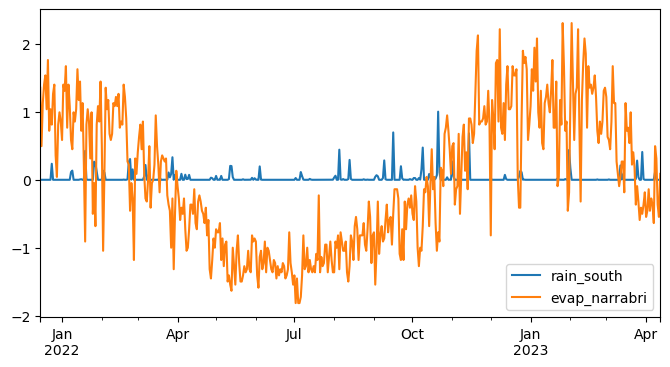

interactive(children=(Dropdown(description='rain_name', options=('rain_south',), value='rain_south'), Dropdown…

In [5]:
# plot the covariates first
covariates_df.plot(figsize=(8,4))

# Now just check that there's no significant correlation of 
# lagged rainfall to soil moisture changes
interact(
    plot_r2_lag,
    rain_data=fixed(covariates_df),
    sm_data=fixed(sm_data),
    rain_name=widgets.Dropdown(options=[_ for _ in covariates_df.columns if 'rain' in _]),
    sm_name=widgets.Dropdown(options=list(sm_data.columns)),
    lag = widgets.IntSlider(min=-2,max=2,step=1,value=0),
)

None

### Convert to jax arrays

In [6]:
# Create our X
covariates = jnp.array(covariates_df.values)

# Create a Y for our observarions and inY for our AR1 covariate
Y = jnp.array(scaled_Y.copy().values)
inY = jnp.array(scaled_Y.copy().values)

# No get our group level data in a jax array
meta_x = probe_meta.copy()
#convert categorical data to ints
meta_x = meta_x.astype('category').apply(lambda x: x.cat.codes)
meta_x = jnp.array(meta_x.values)

# 3. Define our various models using NumPyro

We will fit our Bayesian Linear Regression using NumPyro. 
NumPyro is a probabilistic programming language which helps us to implement a sampling scheme for the paramaters in our model. You can read more about NumPyro [here](https://num.pyro.ai/en/stable/getting_started.html).

We will construct and sample three models:

- Model 1: A partially-pooled linear regression model
- Model 2: A partially-pooled hierarchical model
- Model 3: A non-pooled hierarchical model for comparison

## 3.1 Generic model code

In [7]:
def impute_missing_y(Y_AR1_raw,Y_raw):
    '''
    Code to impute missing soil moisture data within our model.
    '''
    sm_nanidx = np.nonzero(np.isnan(Y_AR1_raw))
    sm_mu = numpyro.sample("sm_mu", dist.Normal(0, 1))
    sm_sigma = numpyro.sample("sm_sigma", dist.HalfNormal(1))

    sm_input = numpyro.sample(
        "sm_input",
        dist.Normal(sm_mu,sm_sigma).expand([sm_nanidx[0].__len__()]).mask(False)
    )
    Y_AR1_impute = Y_AR1_raw.at[sm_nanidx[0],sm_nanidx[1]].set(sm_input)

    if not Y_raw is None:
        Y_impute = Y_raw.at[sm_nanidx[0],sm_nanidx[1]].set(sm_input)
    else:
        Y_impute = None
    return Y_AR1_impute, Y_impute

In [8]:
def time_scan_base(tcarry,tparams):
    '''
    Function to calculate SM_t+1 based on sampled parameters which is compatible with 
    jax.lax.scan for the for loop over time.
    SM_{t+1} = R_t^pow * alpha_r + alpha_trend + alpha_sm * SM_t
    '''
    dval = (tparams['covariates'][0] ** tcarry['pow_fit']) * tcarry['beta_r'] + \
        tcarry['beta_trend'] + jnp.multiply(tparams['ar1'], tcarry['beta_ar1'])
    return tcarry, dval

In [9]:
def time_scan_interaction(tcarry,tparams):
    '''
    Function to calculate SM_t+1 based on sampled parameters which is compatible with 
    jax.lax.scan for the for loop over time.
    SM_{t+1} = R_t^pow * alpha_r + alpha_trend + alpha_sm * SM_t
    Where alpha_r is time varying due to an interaction with SM_t
    '''
    dval = (tparams['covariates'][0] ** tcarry['pow_fit']) * tparams['beta_r'] + \
        tcarry['beta_trend'] + jnp.multiply(tparams['ar1'], tcarry['beta_ar1'])
    return tcarry, dval

## 3.2 Model 1
Here we will define a base model with no interaction for the $\beta_R$ terms. This is a partially-pooled model.

In [10]:
def base_hmodel(Y_AR1,X,meta_X,Y=None):
    '''
    Model description: Base. Partial-pooling.
    '''
    # Counts
    gauges_num = Y_AR1.shape[1]
    # Impute missing values
    Y_AR1, Y = impute_missing_y(Y_AR1,Y)
    # Convert Y into X. Pad to cover off time 0.
    X_pad = jnp.pad(Y_AR1,pad_width=((1,0),(0,0)),mode='edge')
    # Give these as fixed to help our friend JAX in our multi-level model
    plots_num = 2
    treatments_num = 2
    # Now we will sample our group level parameters
    tau_group = 2 # group level variance hyperprior
    with numpyro.plate("sites", plots_num, dim=-2):
        with numpyro.plate("treatment", treatments_num, dim=-1):
            # Sampling for population mean rainfall, trend and AR1 effects
            alpha_r0_mu = numpyro.sample("alpha_r0_mu", dist.Normal(0,tau_group))
            alpha_trend_mu = numpyro.sample("alpha_trend_mu", dist.Normal(0,tau_group))
            alpha_ar1_mu = numpyro.sample("alpha_ar1_mu", dist.Normal(0,tau_group))
    # Now we will sample our individual level parameters using our 
    # group level means to inform our priors
    tau_ind = 1 # individual level variance hyperprior
    with numpyro.plate("gauges", gauges_num, dim=-1) as this_site:
        # Here we are sampling just the intercept for our rainfall effect (no interaction)
        beta_r = numpyro.sample("beta_r", dist.Normal(alpha_r0_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ind))
        beta_trend = numpyro.sample("beta_trend", dist.Normal(alpha_trend_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ind))
        beta_ar1 = numpyro.sample("beta_ar1", dist.Normal(alpha_ar1_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ind)) 
    
    # Homogeneous variables
    # sample a power transform for the rainfall 
    pow_fit = numpyro.sample("pow_fit", dist.LogNormal(1))
    # Sample our measurement noise (common across all sites)
    sigma_meas = numpyro.sample("sigma_meas", dist.Exponential(1))

    # Now we can run the forward model
    carry = {
        'beta_r': beta_r,
        'beta_trend': beta_trend,
        'beta_ar1': beta_ar1,
        'pow_fit': pow_fit,
    }
    scan_covariates = { 
        'covariates': X,
        'ar1': X_pad[:-1,:],
    }
    _, y_out = jax.lax.scan(
        time_scan_base,
        carry,
        scan_covariates
    )

    # record our model predicted soil moisture
    numpyro.deterministic('y_out',y_out)
    # and define the likelihood function
    return numpyro.sample("obs", dist.Normal(y_out, sigma_meas), obs=Y)

## 3.3 Model 2
Here we will define a model with interaction for the $\beta_R$ term, based on the soil moisture from the previous timestep. This is a partially-pooled model.

In [11]:
def interact_hmodel(Y_AR1,X,meta_X,Y=None):
    '''
    Model description: Interaction between rainfall and soil moisture. Partial-pooling.
    '''
    # Counts
    gauges_num = Y_AR1.shape[1]
    # Impute missing values
    Y_AR1, Y = impute_missing_y(Y_AR1,Y)
    # Convert Y into X. Pad to cover off time 0.
    X_pad = jnp.pad(Y_AR1,pad_width=((1,0),(0,0)),mode='edge')
    # Give these as fixed to help our friend JAX in our multi-level model
    plots_num = 2
    treatments_num = 2
    # Now we will sample our group level parameters
    tau_group = 2 # group level variance hyperprior
    with numpyro.plate("sites", plots_num, dim=-2):
        with numpyro.plate("treatment", treatments_num, dim=-1):
            # Sampling for population mean rainfall, trend and AR1 effects
            alpha_r0_mu = numpyro.sample("alpha_r0_mu", dist.Normal(0,tau_group))
            alpha_r1_mu = numpyro.sample("alpha_r1_mu", dist.Normal(0,tau_group))
            alpha_trend_mu = numpyro.sample("alpha_trend_mu", dist.Normal(0,tau_group))
            alpha_ar1_mu = numpyro.sample("alpha_ar1_mu", dist.Normal(0,tau_group))
    # Now we will sample our individual level parameters using our 
    # group level means to inform our priors
    tau_ind = 1 # individual level variance hyperprior
    with numpyro.plate("gauges", gauges_num, dim=-1) as this_site:
        # now get the rainfall effect with interaction term for rainfall 
        # based on the soil moisture (t-1)
        beta_r0 = numpyro.sample("beta_r0", dist.Normal(alpha_r0_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ind))
        beta_r1 = numpyro.sample("beta_r1", dist.Normal(alpha_r1_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ind))
        beta_r = numpyro.deterministic('beta_r',beta_r0 + beta_r1 * X_pad[:-1,this_site])
        # and the other betas
        beta_trend = numpyro.sample("beta_trend", dist.Normal(alpha_trend_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ind))
        beta_ar1 = numpyro.sample("beta_ar1", dist.Normal(alpha_ar1_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ind)) 
    
    # Homogeneous variables
    # sample a power transform for the rainfall 
    pow_fit = numpyro.sample("pow_fit", dist.LogNormal(1))
    # Sample our measurement noise (common across all sites)
    sigma_meas = numpyro.sample("sigma_meas", dist.Exponential(1))

    # Now we can run the forward model
    carry = {
        'beta_trend': beta_trend,
        'beta_ar1': beta_ar1,
        'pow_fit': pow_fit,
    }
    scan_covariates = {
        'beta_r': beta_r,
        'covariates': X,
        'ar1': X_pad[:-1,:],
    }
    _, y_out = jax.lax.scan(
        time_scan_interaction,
        carry,
        scan_covariates
    )

    # record our model predicted soil moisture
    numpyro.deterministic('y_out',y_out)
    # and define the likelihood function
    return numpyro.sample("obs", dist.Normal(y_out, sigma_meas), obs=Y)

## 3.4 Model 3
Here we will define a model with interaction for the $\beta_R$ term, based on the soil moisture from the previous timestep. This is a no-pooling model.

In [12]:
def interact_smodel(Y_AR1,X,meta_X,Y=None):
    '''
    Model description: Interaction between rainfall and soil moisture. No-pooling.
    '''
    # Counts
    gauges_num = Y_AR1.shape[1]
    # Impute missing values
    Y_AR1, Y = impute_missing_y(Y_AR1,Y)
    # Convert Y into X. Pad to cover off time 0.
    X_pad = jnp.pad(Y_AR1,pad_width=((1,0),(0,0)),mode='edge')

    # Now we will sample our individual level parameters
    tau_ind = 1 # individual level variance hyperprior
    with numpyro.plate("gauges", gauges_num, dim=-1) as this_site:
        # now get the rainfall effect with interaction term for rainfall 
        # based on the soil moisture (t-1)
        beta_r0 = numpyro.sample("beta_r0", dist.Normal(0,tau_ind))
        beta_r1 = numpyro.sample("beta_r1", dist.Normal(0,tau_ind))
        beta_r = numpyro.deterministic('beta_r',beta_r0 + beta_r1 * X_pad[:-1,this_site])
        # and the other betas
        beta_trend = numpyro.sample("beta_trend", dist.Normal(0,tau_ind))
        beta_ar1 = numpyro.sample("beta_ar1", dist.Normal(0,tau_ind)) 
    
    # Homogeneous variables
    # sample a power transform for the rainfall 
    pow_fit = numpyro.sample("pow_fit", dist.LogNormal(1))
    # Sample our measurement noise (common across all sites)
    sigma_meas = numpyro.sample("sigma_meas", dist.Exponential(1))

    # Now we can run the forward model
    carry = {
        'beta_trend': beta_trend,
        'beta_ar1': beta_ar1,
        'pow_fit': pow_fit,
    }
    scan_covariates = {
        'beta_r': beta_r,
        'covariates': X,
        'ar1': X_pad[:-1,:],
    }
    _, y_out = jax.lax.scan(
        time_scan_interaction,
        carry,
        scan_covariates
    )

    # record our model predicted soil moisture
    numpyro.deterministic('y_out',y_out)
    # and define the likelihood function
    return numpyro.sample("obs", dist.Normal(y_out, sigma_meas), obs=Y)

## 3.5 Model 4
Here we will define a model with interaction for the $\beta_R$ term, based on the soil moisture from the previous timestep. This is a partially-pooled model, however the measurement error will be independently sampled for each model to capture the variation spatially.

In [13]:
def interact_hmodel_error(Y_AR1,X,meta_X,Y=None):
    '''
    Model description: Interaction between rainfall and soil moisture. Partial-pooling.
    '''
    # Counts
    gauges_num = Y_AR1.shape[1]
    # Impute missing values
    Y_AR1, Y = impute_missing_y(Y_AR1,Y)
    # Convert Y into X. Pad to cover off time 0.
    X_pad = jnp.pad(Y_AR1,pad_width=((1,0),(0,0)),mode='edge')
    # Give these as fixed to help our friend JAX in our multi-level model
    plots_num = 2
    treatments_num = 2
    # Now we will sample our group level parameters
    tau_group = 2 # group level variance hyperprior
    with numpyro.plate("sites", plots_num, dim=-2):
        with numpyro.plate("treatment", treatments_num, dim=-1):
            # Sampling for population mean rainfall, trend and AR1 effects
            alpha_r0_mu = numpyro.sample("alpha_r0_mu", dist.Normal(0,tau_group))
            alpha_r1_mu = numpyro.sample("alpha_r1_mu", dist.Normal(0,tau_group))
            alpha_trend_mu = numpyro.sample("alpha_trend_mu", dist.Normal(0,tau_group))
            alpha_ar1_mu = numpyro.sample("alpha_ar1_mu", dist.Normal(0,tau_group))
    # Now we will sample our individual level parameters using our 
    # group level means to inform our priors
    tau_ind = 1 # individual level variance hyperprior
    with numpyro.plate("gauges", gauges_num, dim=-1) as this_site:
        # now get the rainfall effect with interaction term for rainfall 
        # based on the soil moisture (t-1)
        beta_r0 = numpyro.sample("beta_r0", dist.Normal(alpha_r0_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ind))
        beta_r1 = numpyro.sample("beta_r1", dist.Normal(alpha_r1_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ind))
        beta_r = numpyro.deterministic('beta_r',beta_r0 + beta_r1 * X_pad[:-1,this_site])
        # and the other betas
        beta_trend = numpyro.sample("beta_trend", dist.Normal(alpha_trend_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ind))
        beta_ar1 = numpyro.sample("beta_ar1", dist.Normal(alpha_ar1_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ind)) 
        # Sample our measurement noise (independently across sites)
        sigma_meas = numpyro.sample("sigma_meas", dist.Exponential(1))
    # Homogeneous variables
    # sample a power transform for the rainfall 
    pow_fit = numpyro.sample("pow_fit", dist.LogNormal(1))

    # Now we can run the forward model
    carry = {
        'beta_trend': beta_trend,
        'beta_ar1': beta_ar1,
        'pow_fit': pow_fit,
    }
    scan_covariates = {
        'beta_r': beta_r,
        'covariates': X,
        'ar1': X_pad[:-1,:],
    }
    _, y_out = jax.lax.scan(
        time_scan_interaction,
        carry,
        scan_covariates
    )

    # record our model predicted soil moisture
    numpyro.deterministic('y_out',y_out)
    # and define the likelihood function
    return numpyro.sample("obs", dist.Normal(y_out, sigma_meas), obs=Y)

## 3.6 Model 5
Here we will define a model with interaction for the $\beta_R$ term, based on the soil moisture from the previous timestep. This is a partially-pooled model, including sampling for the group variance.

In [14]:

def interact_hmodel_full(Y_AR1,X,meta_X,Y=None):
    '''
    Model description: Interaction between rainfall and soil moisture. Partial-pooling.
    '''
    # Counts
    gauges_num = Y_AR1.shape[1]
    # Impute missing values
    Y_AR1, Y = impute_missing_y(Y_AR1,Y)
    # Convert Y into X. Pad to cover off time 0.
    X_pad = jnp.pad(Y_AR1,pad_width=((1,0),(0,0)),mode='edge')
    # Give these as fixed to help our friend JAX in our multi-level model
    plots_num = 2
    treatments_num = 2
    # Now we will sample our group level parameters
    mu_tau_group = 2 # group level variance hyperprior
    tau_tau_group = 1 
    with numpyro.plate("sites", plots_num, dim=-2):
        with numpyro.plate("treatment", treatments_num, dim=-1):
            # Sampling for population mean rainfall, trend and AR1 effects
            alpha_r0_mu = numpyro.sample("alpha_r0_mu", dist.Normal(0,mu_tau_group))
            alpha_r1_mu = numpyro.sample("alpha_r1_mu", dist.Normal(0,mu_tau_group))
            alpha_trend_mu = numpyro.sample("alpha_trend_mu", dist.Normal(0,mu_tau_group))
            alpha_ar1_mu = numpyro.sample("alpha_ar1_mu", dist.Normal(0,mu_tau_group))
            # sample for the population variance
            tau_r0 = numpyro.sample("tau_r0", dist.Exponential(tau_tau_group))
            tau_r1 = numpyro.sample("tau_r1", dist.Exponential(tau_tau_group)) 
            tau_trend = numpyro.sample("tau_trend", dist.Exponential(tau_tau_group))
            tau_ar1 = numpyro.sample("tau_ar1", dist.Exponential(tau_tau_group))
    # Now we will sample our individual level parameters using our 
    # group level means to inform our priors
    with numpyro.plate("gauges", gauges_num, dim=-1) as this_site:
        # now get the rainfall effect with interaction term for rainfall 
        # based on the soil moisture (t-1)
        beta_r0 = numpyro.sample("beta_r0", dist.Normal(alpha_r0_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_r0[meta_X[this_site,0],meta_X[this_site,1]]))
        beta_r1 = numpyro.sample("beta_r1", dist.Normal(alpha_r1_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_r1[meta_X[this_site,0],meta_X[this_site,1]]))
        beta_r = numpyro.deterministic('beta_r',beta_r0 + beta_r1 * X_pad[:-1,this_site])
        # and the other betas
        beta_trend = numpyro.sample("beta_trend", dist.Normal(alpha_trend_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_trend[meta_X[this_site,0],meta_X[this_site,1]]))
        beta_ar1 = numpyro.sample("beta_ar1", dist.Normal(alpha_ar1_mu[meta_X[this_site,0],meta_X[this_site,1]],tau_ar1[meta_X[this_site,0],meta_X[this_site,1]])) 
    
    # Homogeneous variables
    # sample a power transform for the rainfall 
    pow_fit = numpyro.sample("pow_fit", dist.LogNormal(1))
    # Sample our measurement noise (common across all sites)
    sigma_meas = numpyro.sample("sigma_meas", dist.Exponential(1))

    # Now we can run the forward model
    carry = {
        'beta_trend': beta_trend,
        'beta_ar1': beta_ar1,
        'pow_fit': pow_fit,
    }
    scan_covariates = {
        'beta_r': beta_r,
        'covariates': X,
        'ar1': X_pad[:-1,:],
    }
    _, y_out = jax.lax.scan(
        time_scan_interaction,
        carry,
        scan_covariates
    )

    # record our model predicted soil moisture
    numpyro.deterministic('y_out',y_out)
    # and define the likelihood function
    return numpyro.sample("obs", dist.Normal(y_out, sigma_meas), obs=Y)


# 4. Prior checking
Now lets sample from out prior distributions, check what these look like with arviz. We will also check what our predictions look like from the priors to ensure we aren't assuming anything too silly.

In [15]:
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)
# here take 100 samples from our priors and make predictions on x_log
prior_samples = Predictive(base_hmodel, num_samples=100)(
    rng_key_, Y_AR1=inY, X=covariates, meta_X=meta_x
)
prior_samples = {k: jnp.expand_dims(v,axis=0) for k, v in prior_samples.items()}
# and put this into arviz for easy plotting
arviz_priors = az.from_dict(
    prior=prior_samples
)

# get the mean model prediciton and CI
mean_mu_prior = jnp.mean(arviz_priors.prior['y_out'].values.squeeze(), axis=0)
hpdi_mu_prior = hpdi(arviz_priors.prior['y_out'].values.squeeze(), ci)
hpdi_sim_prior = hpdi(arviz_priors.prior['obs'].values.squeeze(), ci)

arviz_priors

Inference data with groups:
	> prior

################################################################################
Priors


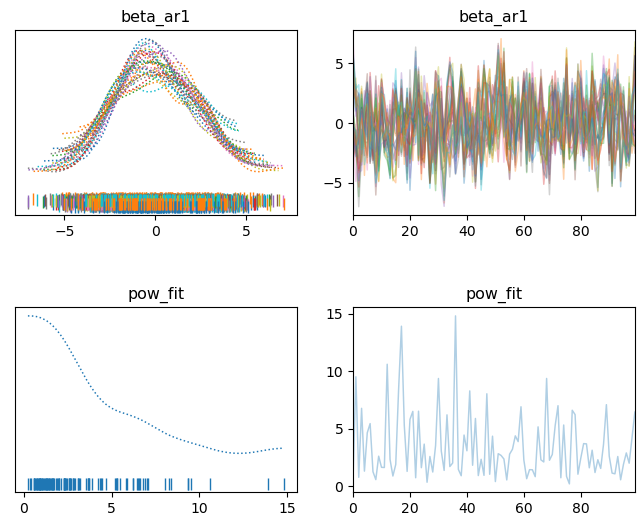

In [16]:
# and now plot the distributions and the simulated data
print('#'*80)
print('Priors')
priors_ax = az.plot_trace(
    arviz_priors.prior, 
    var_names=['beta_ar1','pow_fit'],
    figsize=(8,6),
    rug=True,
    combined=True,
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

In [17]:
interact(
    plot_site_prediction,
    df_Y=fixed(scaled_Y),
    site_ii=widgets.IntSlider(min=0,max=mean_mu_prior.shape[1]-1,step=1,value=0),
    mean_mu=fixed(mean_mu_prior),
    hpdi_mu=fixed(hpdi_mu_prior),
    hpdi_sim=fixed(hpdi_sim_prior),
    ci=fixed(ci),
    save_loc=fixed(None)
)
None

interactive(children=(IntSlider(value=0, description='site_ii', max=31), Output()), _dom_classes=('widget-inte…

# 5. MCMC Sampling

We will use the No U-Turn Sampler (NUTS) to sample from our posterior distributions. This sampler is popular in many PPLs (Stan, pymc, pyro) and should do the job for us with our mere three parameters. We will sample `num_samples` times form the posterior, with `num_warmup` samples taken and discarded before we start proper.

In [22]:
# settings 
num_samples = 1000
num_warmup = 1000
num_chains = 4
max_tree = 10
load_bool = False # load previous runs from arviz netcdf

# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)

# define the sampler - No U-Turn Sampler (NUTS) for each model
kernels_models = {
    'base_hmodel': [NUTS(base_hmodel,max_tree_depth=max_tree), base_hmodel],
    # 'interact_hmodel': [NUTS(interact_hmodel,max_tree_depth=max_tree), interact_hmodel],
    'interact_smodel': [NUTS(interact_smodel,max_tree_depth=max_tree), interact_smodel],
    'interact_hmodel_error': [NUTS(interact_hmodel_error,max_tree_depth=max_tree), interact_hmodel_error],
    'interact_hmodel_full': [NUTS(interact_hmodel_full,max_tree_depth=max_tree), interact_hmodel_full],
}

# save path for outputs - simple for now, no versions etc
arviz_savepath = os.path.join('/project','results','arviz_posterior_{}.nc')
# create storage
mcmc_outputs = {_: {} for _ in kernels_models.keys()}

if not load_bool:
    for kern_name, this_kern in kernels_models.items():
        print('Running model: {}'.format(kern_name))
        # now run the sampler for num_samples+burnin
        mcmc_obj = MCMC(this_kern[0], num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
        mcmc_obj.run(
            rng_key_, Y_AR1=inY,
            X = covariates,
            meta_X=meta_x,
            Y=Y
        )

        # get the samples which will form our posterior
        samples = mcmc_obj.get_samples()

        # get the samples for predictive uncertainty (our linear model + error)
        posterior_predictive = Predictive(
            this_kern[1], posterior_samples=samples, 
            return_sites=[
                'alpha_r0_mu', 'alpha_r1_mu', 'alpha_ar1_mu', 'alpha_trend_mu',
                'beta_r0', 'beta_r1',
                'beta_r', 'beta_rs', # time-varying and static beta_r
                'beta_trend', 'beta_ar1',
                'pow_fit',
                'y_out','sigma_meas','obs'
            ])(rng_key_, Y_AR1=inY, X = covariates, meta_X=meta_x,)

        # get named arvix object
        az_coords = {
            "treatment": ['Control','Treatment'],
            "site": ['WE','WW'],
        }
        az_dims = {
            "alpha_r0_mu": ["site","treatment"],
            "alpha_r1_mu": ["site","treatment"],
            "alpha_trend_mu": ["site","treatment"],
            "alpha_ar1_mu": ["site","treatment"],
        }

        # allow for independent gauge error
        if 'error' in kern_name:
            az_coords["gauge_name"] = scaled_Y.columns.tolist()
            az_dims["sigma_meas"] = ["gauge_name"]
        if 'full' in kern_name:
            az_dims["tau_r0"] = ["site","treatment"]
            az_dims["tau_r1"] = ["site","treatment"]
        # create an arviz object
        arviz_posterior = az.from_numpyro(
            mcmc_obj,
            posterior_predictive=posterior_predictive,
            coords=az_coords,
            dims=az_dims
        )

        # get the mean model prediciton and use hpdi 
        # to compute the credible intervals corresponding to ci
        mean_mu, hpdi_mu, hpdi_sim = calc_mean_hpdi(
            arviz_posterior, ci=ci, y_scaler=y_scaler
        )
        
        mcmc_outputs[kern_name] = {
            'arviz_posterior': arviz_posterior,
            'mean_mu': mean_mu,
            'hpdi_mu': hpdi_mu,
            'hpdi_sim': hpdi_sim
        }
        # and save
        arviz_posterior.to_netcdf(arviz_savepath.format(kern_name))
else:
    # load the arviz objects
    for this_mod in kernels_models.keys():
        tmp_arviz = az.from_netcdf(arviz_savepath.format(this_mod))
        # calculate mean_mu, hpdi_mu and hpdi_sim
        mean_mu, hpdi_mu, hpdi_sim = calc_mean_hpdi(
            tmp_arviz, ci=ci, y_scaler=y_scaler
        ) 
        # and store
        mcmc_outputs[this_mod] = {
            'arviz_posterior': tmp_arviz,
            'mean_mu': mean_mu,
            'hpdi_mu': hpdi_mu,
            'hpdi_sim': hpdi_sim
        }

Examine MCMC diagnostics as needed to check for convergence.

In [19]:
this_model = 'interact_hmodel_full'
az.rhat(mcmc_outputs[this_model]['arviz_posterior'],var_names=['alpha_r0_mu','alpha_r1_mu','tau_r0','tau_r1','sigma_meas'])

<xarray.Dataset>
Dimensions:      (site: 2, treatment: 2)
Coordinates:
  * site         (site) object 'WE' 'WW'
  * treatment    (treatment) object 'Control' 'Treatment'
Data variables:
    alpha_r0_mu  (site, treatment) float64 1.001 1.001 1.0 1.004
    alpha_r1_mu  (site, treatment) float64 1.002 1.002 1.002 1.003
    tau_r0       (site, treatment) float64 1.001 1.005 1.002 1.004
    tau_r1       (site, treatment) float64 1.001 1.002 1.001 1.001
    sigma_meas   float64 1.001

## 5.1 MCMC Results

Plot the posterior distributions for our three parameters and check that they look reasonable. We also want to check the traces (right hand plots) to ensure everything has gone well during the MCMC sampling. Again we won't worry too much about that for this fairly simple case. Notice as well how far our posteriors have deviated from our priors based on the data we have observed.

################################################################################
Posterior


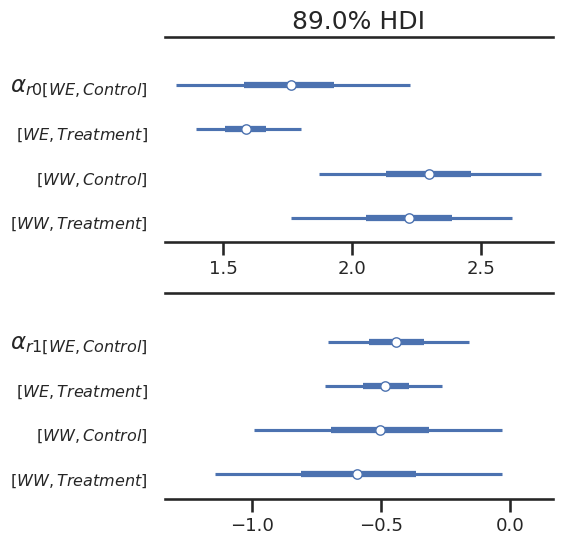

In [60]:
this_model = 'interact_hmodel_full'
print('#'*80)
print('Posterior')
sns.set_context('talk')
x_range = 1.5
fig = plt.figure(figsize=(5,6))
ax1 = plt.subplot(211)
az.plot_forest(
    mcmc_outputs[this_model]['arviz_posterior'],
    var_names=['alpha_r0_mu'],#,'tau_r0','tau_r1'],
    hdi_prob=ci,
    # r_hat = True,
    combined=True,
    show=False,
    ax=ax1
)
ax1 = adjust_forest_labels(ax1)
# set the font size of the xtick labels
for label in ax1.xaxis.get_ticklabels():
    label.set_fontsize(13)
x_lim = ax1.get_xlim()
ax1.set_xlim([np.mean(x_lim)-x_range/2,np.mean(x_lim)+x_range/2])
ax2 = plt.subplot(212)
az.plot_forest(
    mcmc_outputs[this_model]['arviz_posterior'],
    var_names=['alpha_r1_mu'],#,'tau_r0','tau_r1'],
    hdi_prob=ci,
    # r_hat = True,
    combined=True,
    show=False,
    ax=ax2
)
ax2 = adjust_forest_labels(ax2)
# set the font size of the xtick labels
for label in ax2.xaxis.get_ticklabels():
    label.set_fontsize(13)
x_lim = ax2.get_xlim()
ax2.set_xlim([np.mean(x_lim)-x_range/2,np.mean(x_lim)+x_range/2])
ax2.set_title('')
plt.subplots_adjust(hspace=0.25)
fig.savefig(
    os.path.join('/project','figures','posterior_{}_alpha_r0_r1.png'.format(this_model)),
    dpi=300,bbox_inches='tight'
)

################################################################################
Posterior


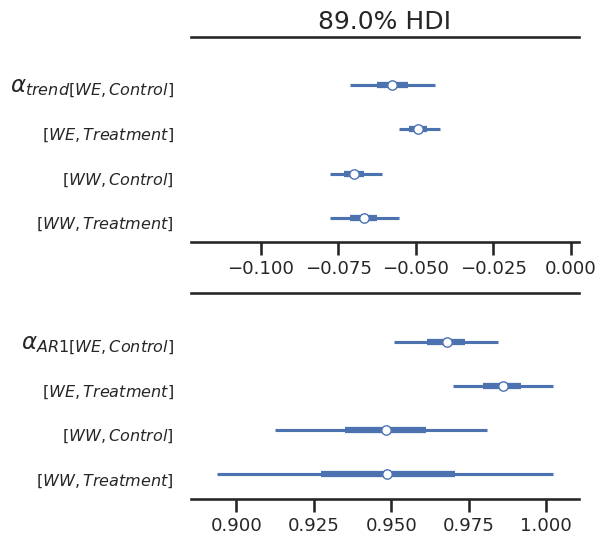

In [59]:
print('#'*80)
print('Posterior')
# sns.set(font_scale=1.1)
sns.set_style('ticks')
sns.set_context('talk')
x_range = 0.125
fig = plt.figure(figsize=(5,6))
ax1 = plt.subplot(211)
az.plot_forest(
    mcmc_outputs['interact_hmodel_full']['arviz_posterior'],
    var_names=['alpha_trend_mu'],#,'tau_r0','tau_r1'],
    hdi_prob=ci,
    # r_hat = True,
    combined=True,
    show=False,
    ax=ax1
)
ax1 = adjust_forest_labels(ax1)
# set the font size of the xtick labels
for label in ax1.xaxis.get_ticklabels():
    label.set_fontsize(13)
x_lim = ax1.get_xlim()
ax1.set_xlim([np.mean(x_lim)-x_range/2,np.mean(x_lim)+x_range/2])
ax2 = plt.subplot(212)
az.plot_forest(
    mcmc_outputs['interact_hmodel_full']['arviz_posterior'],
    var_names=['alpha_ar1_mu'],#,'tau_r0','tau_r1'],
    hdi_prob=ci,
    # r_hat = True,
    combined=True,
    show=False,
    ax=ax2
)
ax2 = adjust_forest_labels(ax2)
# set the font size of the xtick labels
for label in ax2.xaxis.get_ticklabels():
    label.set_fontsize(13)
x_lim = ax2.get_xlim()
ax2.set_xlim([np.mean(x_lim)-x_range/2,np.mean(x_lim)+x_range/2])
ax2.set_title('')
plt.subplots_adjust(hspace=0.25)
fig.savefig(
    os.path.join('/project','figures','posterior_{}_alpha_trend_ar1.png'.format(this_model)),
    dpi=300,bbox_inches='tight'
)

################################################################################
Posterior


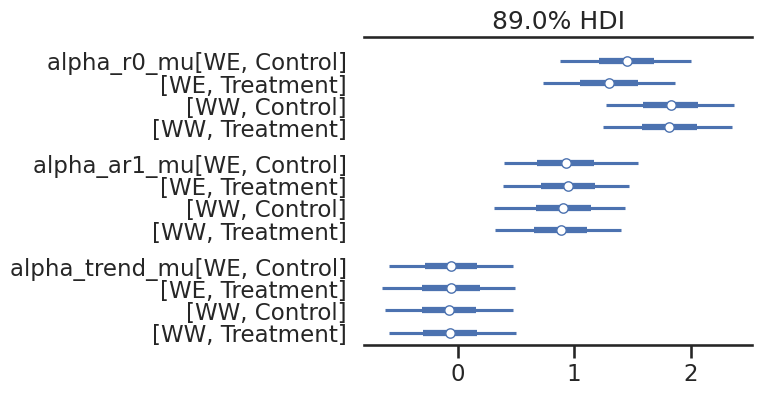

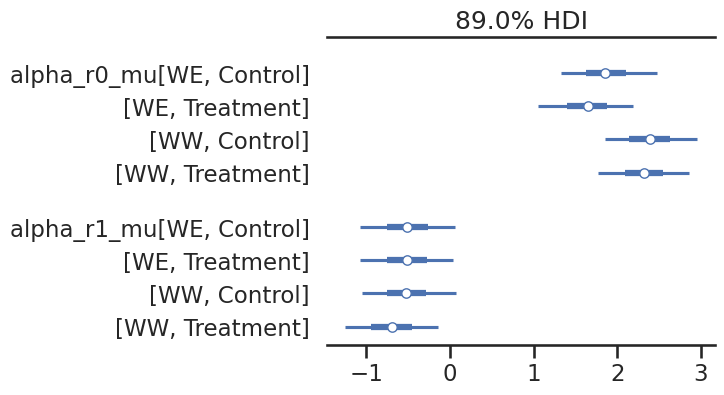

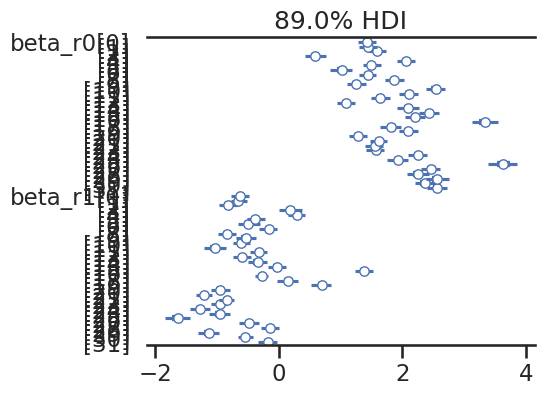

In [58]:
print('#'*80)
print('Posterior')
az.plot_forest(
    mcmc_outputs['base_hmodel']['arviz_posterior'],
    var_names=['alpha_r0_mu','alpha_ar1_mu','alpha_trend_mu'],
    figsize=(5,4),
    hdi_prob=ci,
    # r_hat = True,
    combined=True,
    show=True
)
plt.show()

az.plot_forest(
    mcmc_outputs['interact_hmodel_error']['arviz_posterior'],
    var_names=['alpha_r0_mu','alpha_r1_mu'],
    figsize=(5,4),
    hdi_prob=ci,
    # r_hat = True,
    combined=True,
    show=True
)
plt.show()

az.plot_forest(
    mcmc_outputs['interact_smodel']['arviz_posterior'],
    var_names=['beta_r0','beta_r1'],
    figsize=(5,4),
    hdi_prob=ci,
    # r_hat = True,
    combined=True,
    show=True
)
plt.show()

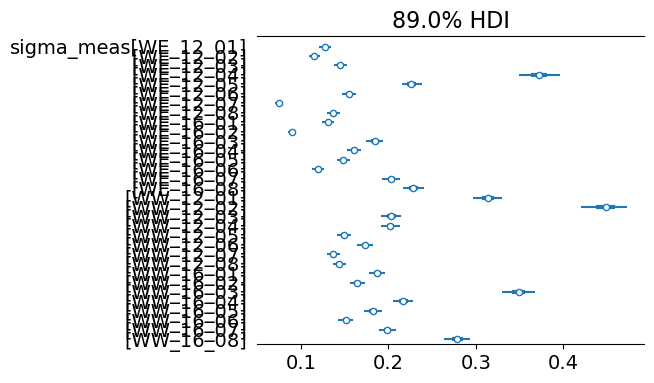

In [ ]:
az.plot_forest(
    mcmc_outputs['interact_hmodel_error']['arviz_posterior'],
    var_names=['sigma_meas'],
    figsize=(5,4),
    hdi_prob=ci,
    # r_hat = True,
    combined=True,
    show=True
)
plt.show()

# 6. Plot the results

We can now plot our model predictions with uncertainty for our selected credible interval (`ci`) - say 68%. Notice that we plot two uncertainty bands, the first is the credible interval for our linear model (blue bands). Essentially, what are range of slopes and intercepts that linear fit could take, reflecting the posteriors for  parameters $a$ and $b$ as we are uncertain of their exact value. 

However, we also have the $\sigma$ parameter. The predictive uncertainty (credible interval given by the orange bands) incorporates model uncertainty and the error ($\epsilon$) which describes our data (which we have assumed to be of the form $\mathcal{N}(0,\sigma)$). 

Here we are simulating possible values of actual data points, as opposed to just the range of possible linear regression lines. This range reflects the shoreline change we could expect for a new event if measured by Coastsat data, rather than our modelled prediction of actual shoreline change. These bands should include approximately 68% of our data points, i.e. approximately matching the `ci` we have chosen.

In [24]:
this_model = 'interact_hmodel_full'
interact(
    plot_site_prediction,
    df_Y=fixed(unscaled_Y),
    site_ii=widgets.IntSlider(min=0,max=mean_mu_prior.shape[1]-1,step=1,value=0),
    mean_mu=fixed(mcmc_outputs[this_model]['mean_mu']),
    hpdi_mu=fixed(mcmc_outputs[this_model]['hpdi_mu']),
    hpdi_sim=fixed(mcmc_outputs[this_model]['hpdi_sim']),
    ci=fixed(ci),
    save_loc=fixed(None)
)
None

interactive(children=(IntSlider(value=0, description='site_ii', max=31), Output()), _dom_classes=('widget-inte…

In [25]:
plot_prediction_bool = True
if plot_prediction_bool:
    for this_model in tqdm(mcmc_outputs.keys()):
        for ii in np.arange(unscaled_Y.shape[1]):
            plot_site_prediction(
                df_Y=unscaled_Y,
                site_ii=ii,
                mean_mu=mcmc_outputs[this_model]['mean_mu'],
                hpdi_mu=mcmc_outputs[this_model]['hpdi_mu'],
                hpdi_sim=mcmc_outputs[this_model]['hpdi_sim'],
                ci=ci,
                save_loc=os.path.join('/project','figures',this_model)
            )

100%|██████████| 4/4 [01:18<00:00, 19.60s/it]


In [26]:
# Now we should check the BSS for the model 
for kern_name, this_result in mcmc_outputs.items(): 
    bss_collect = []
    # compute the BSS for each site - we need to check its positive to ensure we actually have a good model
    for ii, this_gauge in enumerate(unscaled_Y.columns):
        # compute the BSS for this gauge
        mean_mu = this_result['mean_mu']
        curr_obs = unscaled_Y.iloc[:,ii]
        prev_obs = unscaled_Y.shift(1).iloc[:,ii]
        good_idx = np.where(~np.isnan(curr_obs) & ~np.isnan(prev_obs))[0]
        bss = 1 - (mean_squared_error(curr_obs[good_idx],mean_mu[good_idx,ii]) / mean_squared_error(curr_obs[good_idx],prev_obs[good_idx]))
        # print('{} ({}) BSS = {:.2f}'.format(this_gauge,probe_meta.loc[this_gauge,'treatment rep'],bss))
        bss_collect.append(bss)

    bss_collect = np.array(bss_collect)
    print('%'*80)
    print('Model: {}'.format(kern_name))
    print('BSS mean: {:.2f}'.format(np.mean(bss_collect)))
    print('BSS std: {:.2f}'.format(np.std(bss_collect)))
    print('{} sites with BSS > 0.2'.format(np.sum(bss_collect > 0.2)))
    print('{} sites with BSS > 0.3'.format(np.sum(bss_collect > 0.3)))
    print('{} sites with BSS > 0.5'.format(np.sum(bss_collect > 0.5)))
    print('{} sites with BSS > 0.6'.format(np.sum(bss_collect > 0.6)))
    print('{} sites with BSS > 0.7'.format(np.sum(bss_collect > 0.7)))
    print('{} total sites'.format(len(bss_collect)))

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Model: base_hmodel
BSS mean: 0.31
BSS std: 0.31
24 sites with BSS > 0.2
22 sites with BSS > 0.3
10 sites with BSS > 0.5
3 sites with BSS > 0.6
0 sites with BSS > 0.7
32 total sites
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Model: interact_smodel
BSS mean: 0.58
BSS std: 0.11
32 sites with BSS > 0.2
31 sites with BSS > 0.3
25 sites with BSS > 0.5
16 sites with BSS > 0.6
4 sites with BSS > 0.7
32 total sites
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Model: interact_hmodel_error
BSS mean: 0.58
BSS std: 0.11
32 sites with BSS > 0.2
31 sites with BSS > 0.3
23 sites with BSS > 0.5
17 sites with BSS > 0.6
4 sites with BSS > 0.7
32 total sites
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Model: interact_hmodel_full
BSS mean: 0.58
BSS std: 0.11
32 sites with BSS > 0.2
32 sites with BSS > 0.3
25 sites wit

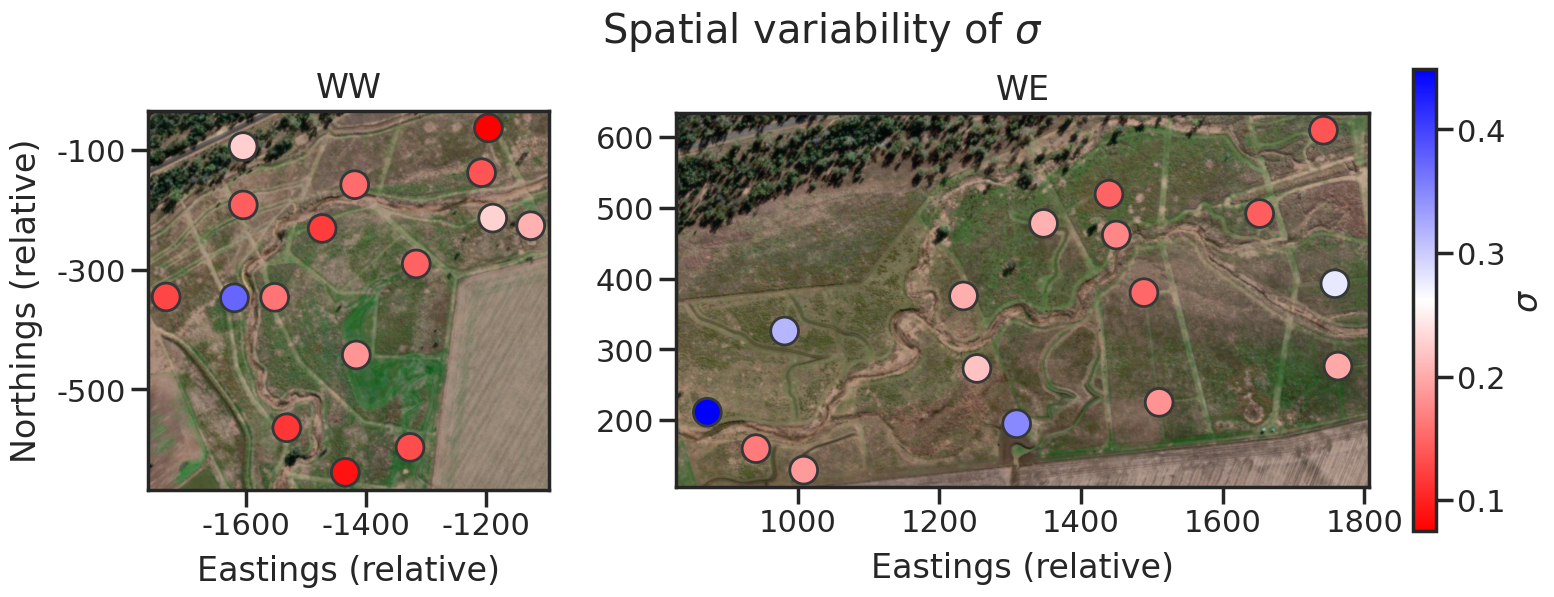

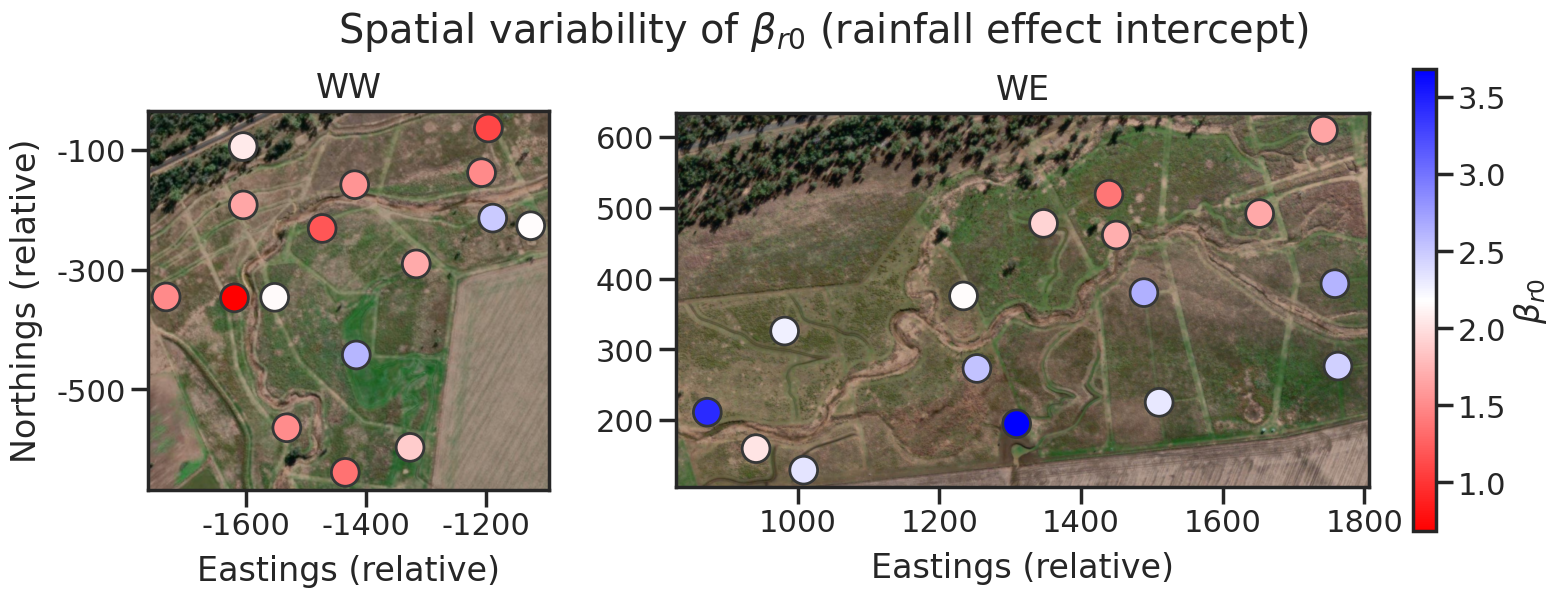

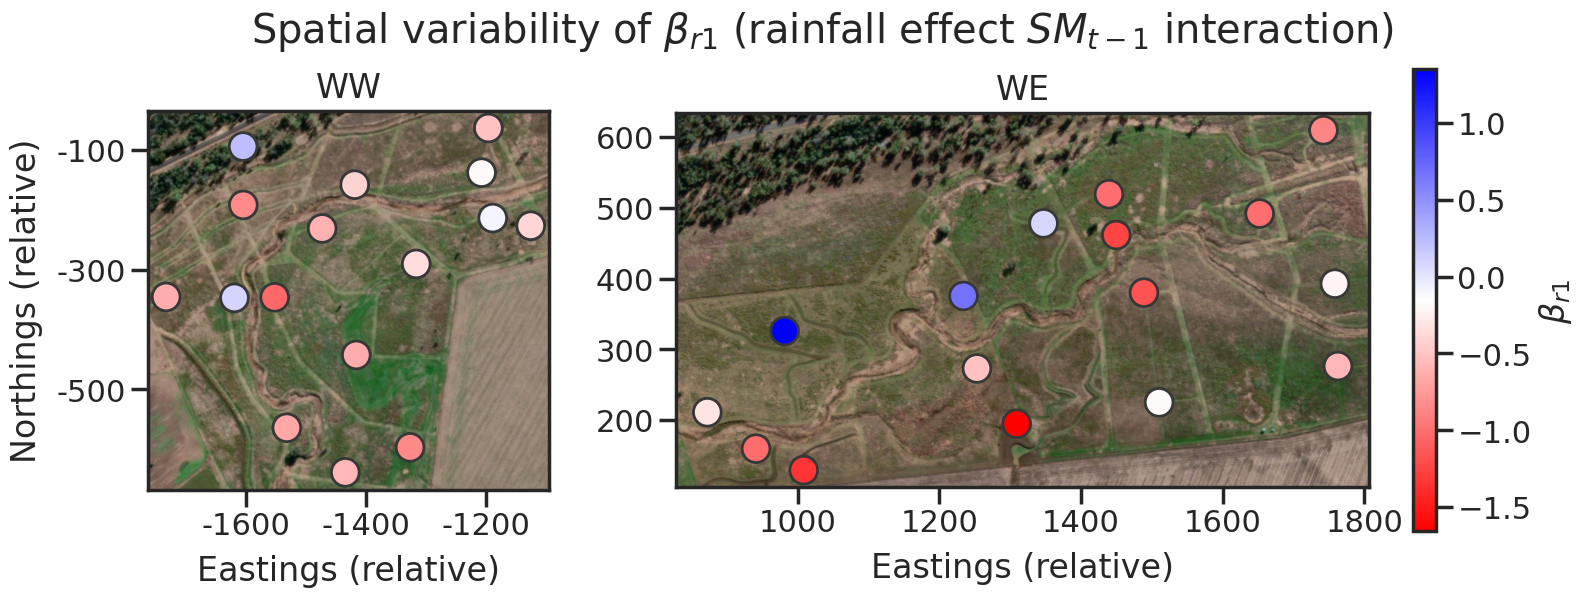

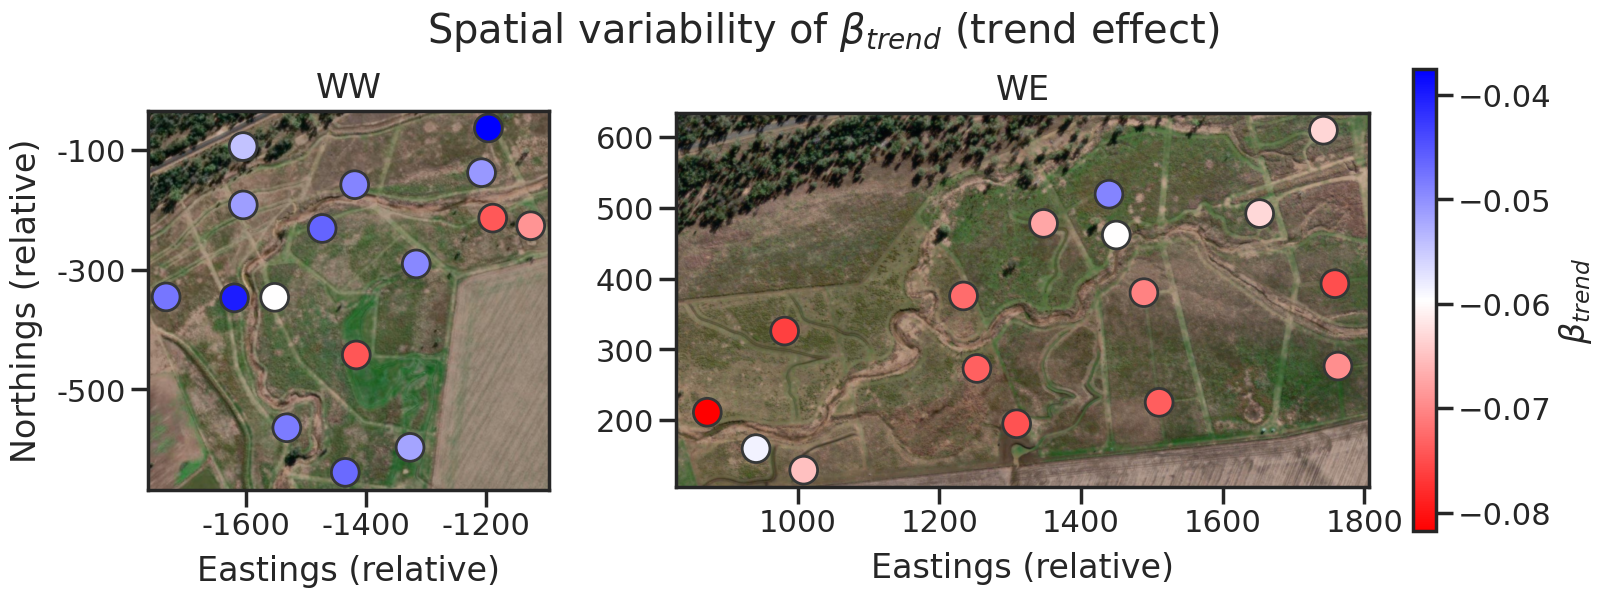

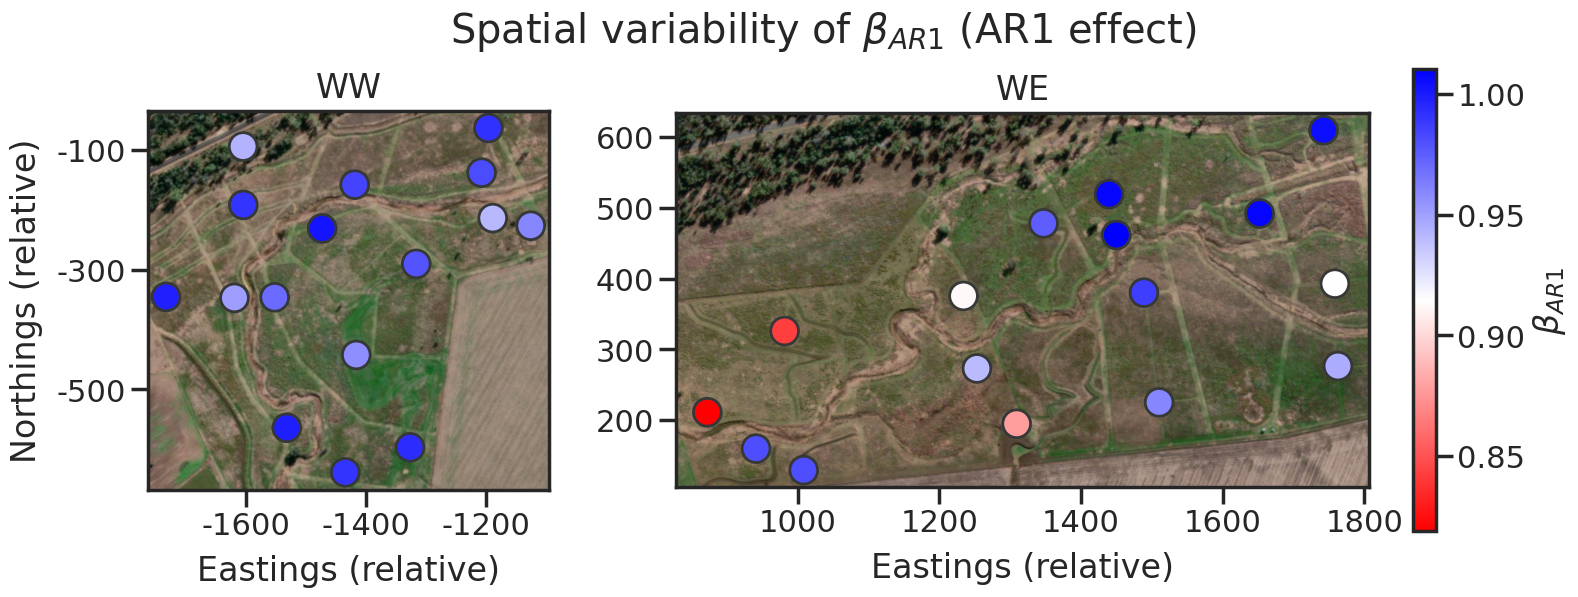

In [29]:
plot_saveloc = os.path.join('/project','figures','spatial')
# spatial error variance analysis
var_model = 'interact_hmodel_error'
# get the variance per site as a measure of the residuals structure
variance_mu = mcmc_outputs[var_model]['arviz_posterior'].posterior.mean(dim=['chain','draw'])['sigma_meas'].to_dataframe()
loc_residuals = loc_meta.drop_duplicates().copy()
loc_residuals['variance'] = variance_mu['sigma_meas'].values
# now get the gauge level effects to assess any spatial characteristics
gauge_level_model = 'interact_hmodel_full'
gauge_beta_r0 = mcmc_outputs[gauge_level_model]['arviz_posterior'].posterior.mean(dim=['chain','draw'])['beta_r0'].to_dataframe()
gauge_beta_r1 = mcmc_outputs[gauge_level_model]['arviz_posterior'].posterior.mean(dim=['chain','draw'])['beta_r1'].to_dataframe()
loc_residuals['beta_r0'] = gauge_beta_r0['beta_r0'].values
loc_residuals['beta_r1'] = gauge_beta_r1['beta_r1'].values
gauge_beta_trend = mcmc_outputs[gauge_level_model]['arviz_posterior'].posterior.mean(dim=['chain','draw'])['beta_trend'].to_dataframe()
loc_residuals['beta_trend'] = gauge_beta_trend['beta_trend'].values
gauge_beta_ar1 = mcmc_outputs[gauge_level_model]['arviz_posterior'].posterior.mean(dim=['chain','draw'])['beta_ar1'].to_dataframe()
loc_residuals['beta_ar1'] = gauge_beta_ar1['beta_ar1'].values

# now plot these all spatially
plot_probe_locations(
    loc_residuals,plot_col='variance',
    plot_title=r'Spatial variability of $\sigma$',
    save_loc = plot_saveloc
)
plot_probe_locations(
    loc_residuals,plot_col='beta_r0',
    plot_title=r'Spatial variability of $\beta_{r0}$ (rainfall effect intercept)',
    save_loc = plot_saveloc
)
plot_probe_locations(
    loc_residuals,plot_col='beta_r1',
    plot_title=r'Spatial variability of $\beta_{r1}$ (rainfall effect $SM_{t-1}$ interaction)',
    save_loc = plot_saveloc
)
plot_probe_locations(
    loc_residuals,plot_col='beta_trend',
    plot_title=r'Spatial variability of $\beta_{trend}$ (trend effect)',
    save_loc = plot_saveloc
)
plot_probe_locations(
    loc_residuals,plot_col='beta_ar1',
    plot_title=r'Spatial variability of $\beta_{AR1}$ (AR1 effect)',
    save_loc = plot_saveloc
)
#output the geopandas dataframe as a geojson
loc_residuals.to_file(
    os.path.join('/project','results','{}_spatial_residuals.geojson'.format(var_model)), 
    driver='GeoJSON'
)